# Exoplanets - Data Modelling

In this notebook we will model the data provided in the dataset and evaluate the results. After the implementation of data-loading fuctions, two models will be used to evaluate how different algorimths classify the dataset.


In [1]:
import numpy as np
import datetime, os
import matplotlib.pyplot as plt

### Import data in train and test set

In [2]:
TRAIN_SET_PATH = "data/Exoplanets/exoTrain.csv"
TEST_SET_PATH = "data/Exoplanets/exoTest.csv"

In [3]:
# define label column
LABEL_COLUMN_INDEX = 0

In [4]:
def data_loader_txt(path, skiprows=1, delimiter=',', normalize=True):
    raw = np.loadtxt(path, skiprows=1, delimiter=',')
    x = raw[:, LABEL_COLUMN_INDEX+1:]
    y = raw[:, LABEL_COLUMN_INDEX, np.newaxis] - 1. # -1 to report label in the range 0-1
    
    if normalize: # standard normalization
        x = ((x - np.mean(x, axis=1).reshape(-1,1)) / np.std(x, axis=1).reshape(-1,1))
    return x, y

In [5]:
# loading train set
x_train, y_train = data_loader_txt(TRAIN_SET_PATH) 
# loading test set
x_test, y_test = data_loader_txt(TEST_SET_PATH) 

### Baseline model

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

In [7]:
svc = LinearSVC(C=0.5, max_iter=3000, verbose=0,  class_weight='balanced')
print("SVC - baseline training...")
svc.fit(x_train, np.squeeze(y_train))
y_pred = svc.predict(x_test)
print("SVC - training and evaluation completed")

SVC - baseline training...
SVC - training and evaluation completed


C:\Users\Francesco\miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
# calculare confusion matrix
scv_cm = confusion_matrix(y_true=np.squeeze(y_test), y_pred=y_pred)

In [9]:
def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n \nAccuracy={:0.3f}; Missclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

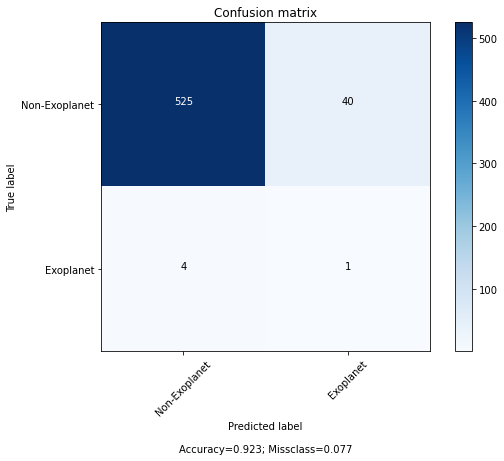

Recall score: 0.2


In [10]:
plot_confusion_matrix(scv_cm, ["Non-Exoplanet", "Exoplanet"], normalize=False)
print("Recall score:",recall_score(y_test, y_pred))

### Tensorflow CNN model 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Input, concatenate, Activation
from tensorflow.keras.optimizers import Adam

%load_ext tensorboard

In [12]:
# expand one dimension to work with 1D CNN layer
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

##### Model definition

In [13]:
def create_model():
    return tf.keras.models.Sequential([
        Conv1D(filters=8, kernel_size=5, activation='relu', input_shape=x_train.shape[1:]),
        MaxPool1D(strides=4),
        BatchNormalization(),
        Conv1D(filters=16, kernel_size=3, activation='relu'),
        MaxPool1D(strides=4),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPool1D(strides=4),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPool1D(strides=4),
        Flatten(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

In [14]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

##### Model compile and train

In [15]:
def train_model(epochs, batch_size=32):
    model = create_model()
    print("Model architecture in training:")
    print(model.summary())
    print("\n")
    model.compile(optimizer=Adam(3e-5),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    model.fit(batch_generator(x_train, y_train, batch_size), 
              epochs=epochs, 
              validation_data=(x_test, y_test),
              steps_per_epoch=x_train.shape[1]//batch_size,
              callbacks=[tensorboard_callback])

In [16]:
train_model(epochs=100)

Model architecture in training:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3193, 8)           48        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 798, 8)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 798, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 796, 16)           400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 16)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 199, 16)           64        
_________________________________________________________________
conv1d_2 (Conv1D)       

In [18]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 20036), started 0:01:33 ago. (Use '!kill 20036' to kill it.)

### Final notes

Two models have been implemeted in this notebook a SVC and a (small) CNN. The results prove that the CNN did worked better than the SVC. Nevertheless, some remarks are reported below:

- SVC could improve its performances by working on a smaller set of engineered features.
- CNN should be did archive respectivelly 81% and 100% of recall in train and test set. Since the test set is actually quite small it might makes sense to revaluate the results with a different split i.e cross-validation.
- No specific HPO has been performed. That's could improve the results/robustness of both algorithms.